* Loading the csv file 
* Taking out the desired column

In [58]:

import pandas as pd 
from sklearn.model_selection import train_test_split
train_link = 'https://drive.google.com/file/d/1lKLs-uyQ85JkoXhk-Hwom5q9RRn9Fbd4/view'
train_id= train_link.split('/')[-2]

#Prefix url
start_url ='https://drive.google.com/uc?id=' 

#The dataframe
train_oil = pd.read_csv(start_url + train_id ,encoding="latin-1")
use_oil = train_oil[['Price','Date']]

* importing numpy
* showing the prices plot

<AxesSubplot:>

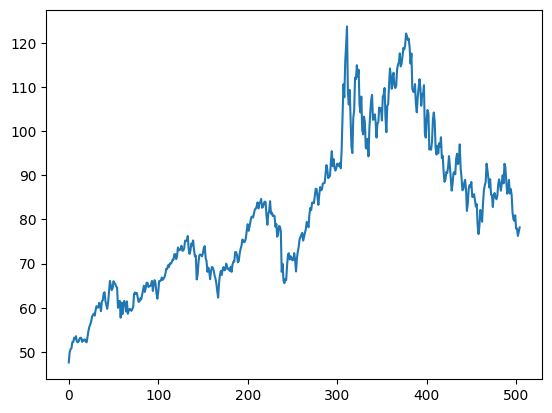

In [59]:
import numpy as np
np.random.seed(0)
price=(use_oil['Price'])
price.plot()

In [60]:
value = price.values


* processing the data using the MinMaxScaler 
* all prices range from 0-1

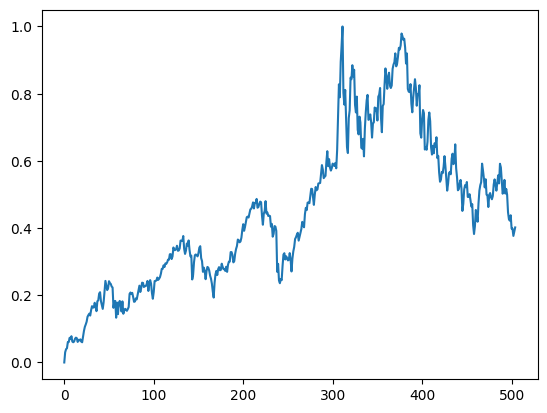

In [61]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(value).reshape(-1,1))
plt.plot(ds_scaled)

* splitting the data into train and cross_validation 

In [62]:
train_size = int(len(x_train)*0.70)
test_size = len(x_train) - train_size
ds_train, ds_test = x_train[0:train_size,:], x_train[train_size:len(x_train),:1]

* making input and output data for model by choosing 100 day prices as input and 101th day as output

In [63]:
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [64]:
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)


* reshaping for fitting into model

In [65]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print(X_train.shape)

(252, 100, 1)


* Loading the model using keras

In [66]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

* Defining the layers and parameters of model

In [67]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


* Fitting the model by training it using the dataset and cross validation

In [68]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
4/4 [==============================] - 6s 375ms/step - loss: 0.1406 - val_loss: 0.0089
Epoch 2/100
4/4 [==============================] - 0s 106ms/step - loss: 0.0254 - val_loss: 0.0450
Epoch 3/100
4/4 [==============================] - 0s 112ms/step - loss: 0.0136 - val_loss: 0.0054
Epoch 4/100
4/4 [==============================] - 1s 155ms/step - loss: 0.0161 - val_loss: 0.0086
Epoch 5/100
4/4 [==============================] - 0s 134ms/step - loss: 0.0125 - val_loss: 0.0049
Epoch 6/100
4/4 [==============================] - 1s 128ms/step - loss: 0.0093 - val_loss: 0.0166
Epoch 7/100
4/4 [==============================] - 0s 108ms/step - loss: 0.0097 - val_loss: 0.0065
Epoch 8/100
4/4 [==============================] - 0s 114ms/step - loss: 0.0070 - val_loss: 0.0040
Epoch 9/100
4/4 [==============================] - 0s 102ms/step - loss: 0.0085 - val_loss: 0.0040
Epoch 10/100
4/4 [==============================] - 0s 110ms/step - loss: 0.0066 - val_loss: 0.0092
Epoch 11/

* Prediction on X_train and X_test to see the results

In [69]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 56ms/step


In [70]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

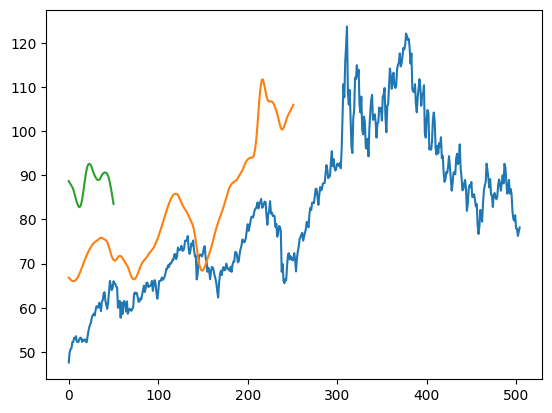

In [71]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

* combining the train_predict and test_predict by applying the inverse also plotting the graph

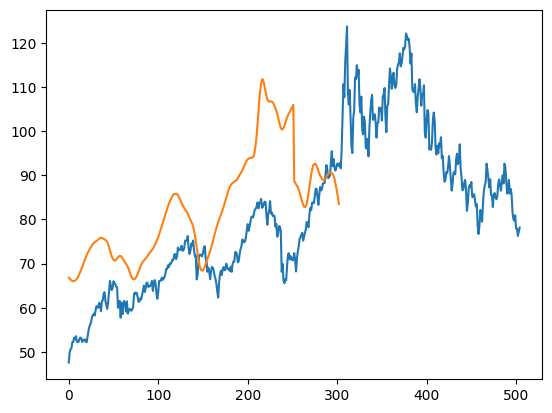

In [72]:
test = np.vstack((train_predict,test_predict))
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

* making the input for 1st day of prediction by taking last 100 day prices.

In [73]:
#Getting the last 100 days records
fut_inp = ds_test[len(ds_test) - 100:]
fut_inp = fut_inp.reshape(1,-1)

#A temporary input
tmp_inp = list(fut_inp)
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()


* making the use of model to predict next 30 days output and store in a lst_output list

In [74]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

* making the data frame of final predicted prices of oil

In [75]:
#Entends helps us to fill the missing value with approx value
ds_new = ds_scaled.tolist()
ds_new.extend(lst_output)
next_30_days_prices = normalizer.inverse_transform(ds_new).tolist()[-30:]
prices = []
for i in next_30_days_prices:
    prices.append(i[0])

next_days = ['30-Nov-22']
for i in range(1,30):
    next_days.append(f'{i}-Dec-22')

predictions = pd.DataFrame(data={"prices": prices, "Date" :next_days})
predictions.set_index(['Date'], inplace=True)
predictions.to_csv('predictions.csv')


* plotting the final graph combining the original and the predicted prices

535


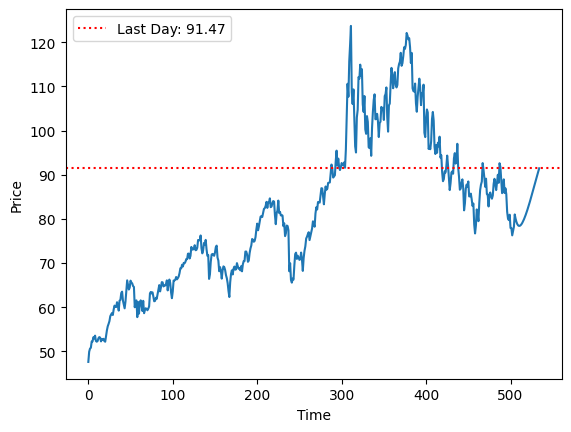

In [76]:
#Plotting final results with predicted value after 30 Days

combine_prices = normalizer.inverse_transform(ds_new).tolist()
plt.plot(combine_prices,)
print(len(combine_prices))
plt.ylabel("Price")
plt.xlabel("Time")
# plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=combine_prices[len(combine_prices)-1], color = 'red', linestyle = ':', label = 'Last Day: {0}'.format(round(float(*combine_prices[len(combine_prices)-1]),2)))
plt.legend()